In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
IMAGE_SIZE=128
BATCH_SIZE=16
EPOCHS=50
CHANNELS=3

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/artifacts",
                                                    shuffle=True,
                                                    image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE)

Found 10119 files belonging to 10 classes.


In [6]:
class_names=dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
len(dataset)

633

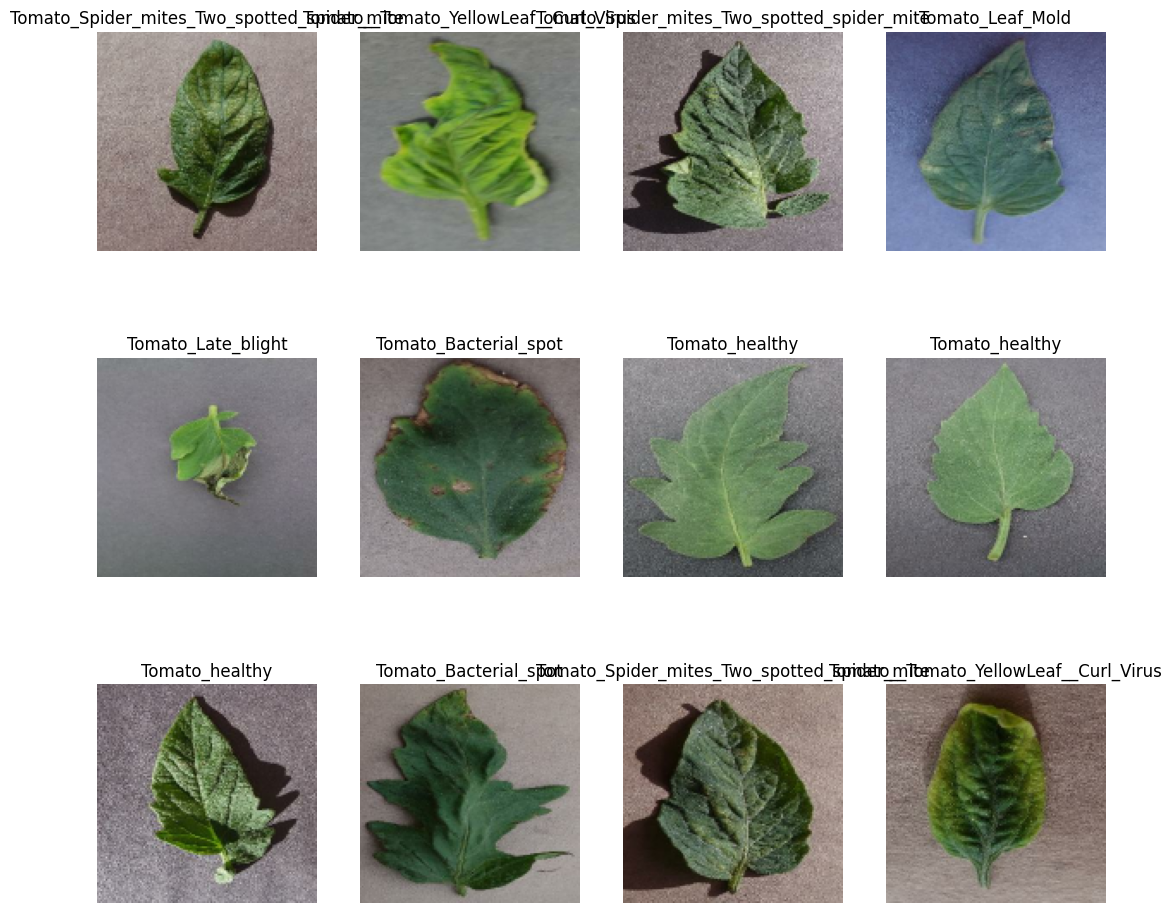

In [8]:
plt.figure(figsize=(13,12))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
     ax=plt.subplot(3,4,i+1)
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]])
     plt.axis("off")

In [9]:
 # 70% ==> TRAINING DATA
 # 30% ==> 10% VALIDATION, 20% TEST

In [10]:
train_size=0.7
len(dataset)*train_size

443.09999999999997

In [11]:
train_ds=dataset.take(222)
len(train_ds)

222

In [12]:
test_ds=dataset.skip(222)
len(test_ds)

411

In [13]:
val_size=0.1
len(dataset)*val_size

63.300000000000004

In [14]:
val_ds=test_ds.take(31)
len(val_ds)

31

In [15]:
test_ds=test_ds.skip(31)
len(test_ds)

380

In [16]:
def get_dataset_partitions_tf(ds,train_split=0.7,val_split=0.15,test_split=0.15,shuffle=True,shuffle_size=32):
  ds_size=len(ds)

  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)

  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)

  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).skip(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds




In [17]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [18]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [19]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
                     ])

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])



In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=10
model=models.Sequential([resize_and_rescale,

                          layers.Conv2D(32,(3,3),activation='relu',input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), padding='same'),
                          layers.BatchNormalization(),
                          layers.MaxPool2D((2,2)),

                          layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'),
                          layers.BatchNormalization(),
                          layers.MaxPool2D((2,2)),

                          layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'),
                          layers.BatchNormalization(),
                          layers.MaxPool2D((2,2)),

                          layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'),
                          layers.BatchNormalization(),
                          layers.MaxPool2D((2,2)),

                          layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'),
                          layers.BatchNormalization(),
                          layers.MaxPool2D((2,2)),
                          layers.Dropout(0.5),

                          layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
                          layers.BatchNormalization(),
                          layers.MaxPool2D((2,2)),
                          layers.Dropout(0.5),

                          layers.Flatten(),
                          layers.Dense(64,activation='relu'),
                          layers.BatchNormalization(),
                          layers.Dropout(0.5),
                          layers.Dense(n_classes,activation='softmax')


])
model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (16, 128, 128, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (16, 128, 128, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (16, 128, 128, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (16, 64, 64, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (16, 64, 64, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (16, 64, 64, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (16, 32, 32, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (16, 32, 32, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (16, 32, 32, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (16, 16, 16, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (16, 16, 16, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (16, 16, 16, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (16, 8, 8, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (16, 8, 8, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (16, 8, 8, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (16, 4, 4, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (16, 4, 4, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (16, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (16, 4, 4, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (16, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (16, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (16, 256)              │             

 Total params: 185,866 (726.04 KB)

 Trainable params: 185,034 (722.79 KB)

 Non-trainable params: 832 (3.25 KB)

In [25]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
              )

In [26]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [27]:
history=model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds,callbacks=[callbacks])

Epoch 1/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2840 - loss: 2.5170

443/443 ━━━━━━━━━━━━━━━━━━━━ 3335s 2s/step - accuracy: 0.2843 - loss: 2.5159 - val_accuracy: 0.2403 - val_loss: 2.4945 - learning_rate: 0.0010
Epoch 2/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5485 - loss: 1.3592

443/443 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.5486 - loss: 1.3590 - val_accuracy: 0.4604 - val_loss: 1.7748 - learning_rate: 0.0010
Epoch 3/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.6297 - loss: 1.0716 - val_accuracy: 0.4361 - val_loss: 2.1577 - learning_rate: 0.0010
Epoch 4/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6631 - loss: 0.9663

443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.6632 - loss: 0.9661 - val_accuracy: 0.6608 - val_loss: 0.9263 - learning_rate: 0.0010
Epoch 5/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.7240 - loss: 0.8149 - val_accuracy: 0.5265 - val_loss: 1.4917 - learning_rate: 0.0010
Epoch 6/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.7499 - loss: 0.7274 - val_accuracy: 0.5174 - val_loss: 1.7183 - learning_rate: 0.0010
Epoch 7/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7702 - loss: 0.6880

443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.7702 - loss: 0.6880 - val_accuracy: 0.7629 - val_loss: 0.7063 - learning_rate: 0.0010
Epoch 8/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - accuracy: 0.7894 - loss: 0.6192 - val_accuracy: 0.5835 - val_loss: 1.4884 - learning_rate: 0.0010
Epoch 9/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.8120 - loss: 0.5618 - val_accuracy: 0.5056 - val_loss: 1.6237 - learning_rate: 0.0010
Epoch 10/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.8228 - loss: 0.5323 - val_accuracy: 0.7151 - val_loss: 0.8419 - learning_rate: 0.0010
Epoch 11/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8511 - loss: 0.4483

443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.8511 - loss: 0.4483 - val_accuracy: 0.8599 - val_loss: 0.4148 - learning_rate: 5.0000e-04
Epoch 12/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.8744 - loss: 0.3992 - val_accuracy: 0.8271 - val_loss: 0.5541 - learning_rate: 5.0000e-04
Epoch 13/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.8771 - loss: 0.3861 - val_accuracy: 0.8062 - val_loss: 0.5941 - learning_rate: 5.0000e-04
Epoch 14/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.8832 - loss: 0.3509 - val_accuracy: 0.7610 - val_loss: 0.8492 - learning_rate: 5.0000e-04
Epoch 15/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8947 - loss: 0.3243

443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.8947 - loss: 0.3243 - val_accuracy: 0.9070 - val_loss: 0.2613 - learning_rate: 2.5000e-04
Epoch 16/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9040 - loss: 0.2953

443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9041 - loss: 0.2953 - val_accuracy: 0.9208 - val_loss: 0.2212 - learning_rate: 2.5000e-04
Epoch 17/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9189 - loss: 0.2715 - val_accuracy: 0.8697 - val_loss: 0.3787 - learning_rate: 2.5000e-04
Epoch 18/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.9167 - loss: 0.2737 - val_accuracy: 0.8042 - val_loss: 0.7282 - learning_rate: 2.5000e-04
Epoch 19/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.9146 - loss: 0.2593 - val_accuracy: 0.8291 - val_loss: 0.5914 - learning_rate: 2.5000e-04
Epoch 20/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9251 - loss: 0.2298

443/443 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.9251 - loss: 0.2298 - val_accuracy: 0.9188 - val_loss: 0.2141 - learning_rate: 1.2500e-04
Epoch 21/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.9261 - loss: 0.2219 - val_accuracy: 0.9005 - val_loss: 0.3142 - learning_rate: 1.2500e-04
Epoch 22/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9409 - loss: 0.1921 - val_accuracy: 0.8861 - val_loss: 0.3290 - learning_rate: 1.2500e-04
Epoch 23/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9368 - loss: 0.1943

443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9368 - loss: 0.1944 - val_accuracy: 0.9470 - val_loss: 0.1587 - learning_rate: 1.2500e-04
Epoch 24/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.9371 - loss: 0.2071 - val_accuracy: 0.8769 - val_loss: 0.4404 - learning_rate: 1.2500e-04
Epoch 25/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9404 - loss: 0.1903 - val_accuracy: 0.9057 - val_loss: 0.2973 - learning_rate: 1.2500e-04
Epoch 26/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.9424 - loss: 0.1887 - val_accuracy: 0.9378 - val_loss: 0.1811 - learning_rate: 1.2500e-04
Epoch 27/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.9447 - loss: 0.1787 - val_accuracy: 0.8933 - val_loss: 0.3499 - learning_rate: 6.2500e-05
Epoch 28/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.9410 - loss: 0.1856 - val_accuracy: 0.9384 - val_loss: 0.1875 - learning_rate: 6.2500e-05
Epoch 29/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - a

In [28]:
scores = model.evaluate(test_ds)


96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9479 - loss: 0.1492


In [29]:
scores

[0.15195462107658386, 0.9515389800071716]

In [31]:
history.params


{'verbose': 1, 'epochs': 50, 'steps': 443}

In [32]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [33]:
len(history.history['loss'])


33

In [34]:
history.history['loss'][:5]

[2.035773277282715,
 1.2897130250930786,
 1.0467802286148071,
 0.9126594662666321,
 0.8004366755485535]

In [36]:
val_acc


[0.24034053087234497,
 0.46037983894348145,
 0.4361492991447449,
 0.6607727408409119,
 0.5265225768089294,
 0.5173543095588684,
 0.7629338502883911,
 0.5834970474243164,
 0.5055664777755737,
 0.71512770652771,
 0.8598559498786926,
 0.8271119594573975,
 0.8061558604240417,
 0.7609692215919495,
 0.9070072174072266,
 0.9207596778869629,
 0.8696790933609009,
 0.8041912317276001,
 0.8290766477584839,
 0.9187950491905212,
 0.9004583954811096,
 0.8860510587692261,
 0.9469547867774963,
 0.876882791519165,
 0.9056974649429321,
 0.9377865195274353,
 0.8932547569274902,
 0.9384413957595825,
 0.9024230241775513,
 0.9004583954811096,
 0.9246889352798462,
 0.9417157769203186,
 0.918140172958374]

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [39]:
acc

[0.38275960087776184,
 0.5712471604347229,
 0.6379796862602234,
 0.6914503574371338,
 0.7267212271690369,
 0.7566308975219727,
 0.781602680683136,
 0.7943001985549927,
 0.81292325258255,
 0.8308408856391907,
 0.8584932088851929,
 0.8707674741744995,
 0.8747178316116333,
 0.8768340945243835,
 0.8951749205589294,
 0.907025933265686,
 0.9119638800621033,
 0.9116817116737366,
 0.9164785742759705,
 0.9262133240699768,
 0.9267776608467102,
 0.9353837370872498,
 0.9324209690093994,
 0.9394751787185669,
 0.93707674741745,
 0.9390519261360168,
 0.9462471604347229,
 0.943566620349884,
 0.947093665599823,
 0.9510440230369568,
 0.9509029388427734,
 0.9497742652893066,
 0.9569694995880127]

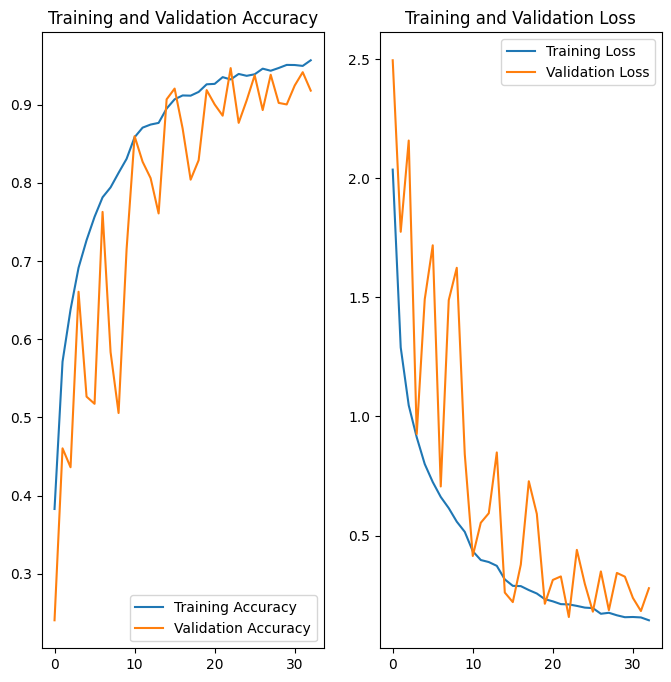

In [40]:
EPOCHS = 33
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Image shape: (128, 128, 3)
Image dtype: float32
Min pixel value: 12.75
Max pixel value: 186.5


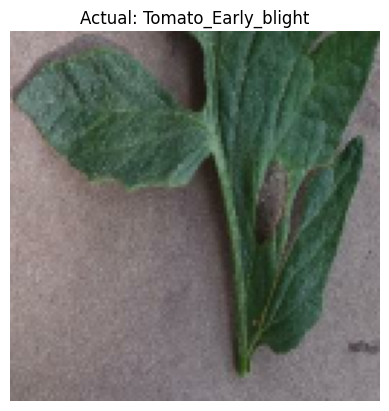

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted label: Tomato_Early_blight


In [51]:
import numpy as np
import matplotlib.pyplot as plt

for image_batch, label_batch in test_ds:
    first_image = image_batch[0].numpy()
    first_label = int(label_batch[0])

    print("Image shape:", first_image.shape)
    print("Image dtype:", first_image.dtype)
    print("Min pixel value:", first_image.min())
    print("Max pixel value:", first_image.max())

    # ✅ Convert float image (0–255) to uint8
    img_to_display = first_image.astype("uint8")

    plt.imshow(img_to_display)
    plt.axis('off')
    plt.title(f"Actual: {class_names[first_label]}")
    plt.show()

    batch_prediction = model.predict(image_batch)
    predicted_label = class_names[np.argmax(batch_prediction[0])]
    print("Predicted label:", predicted_label)

    break


In [50]:
from PIL import Image
Image.fromarray(first_image).convert("RGB").show()


In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


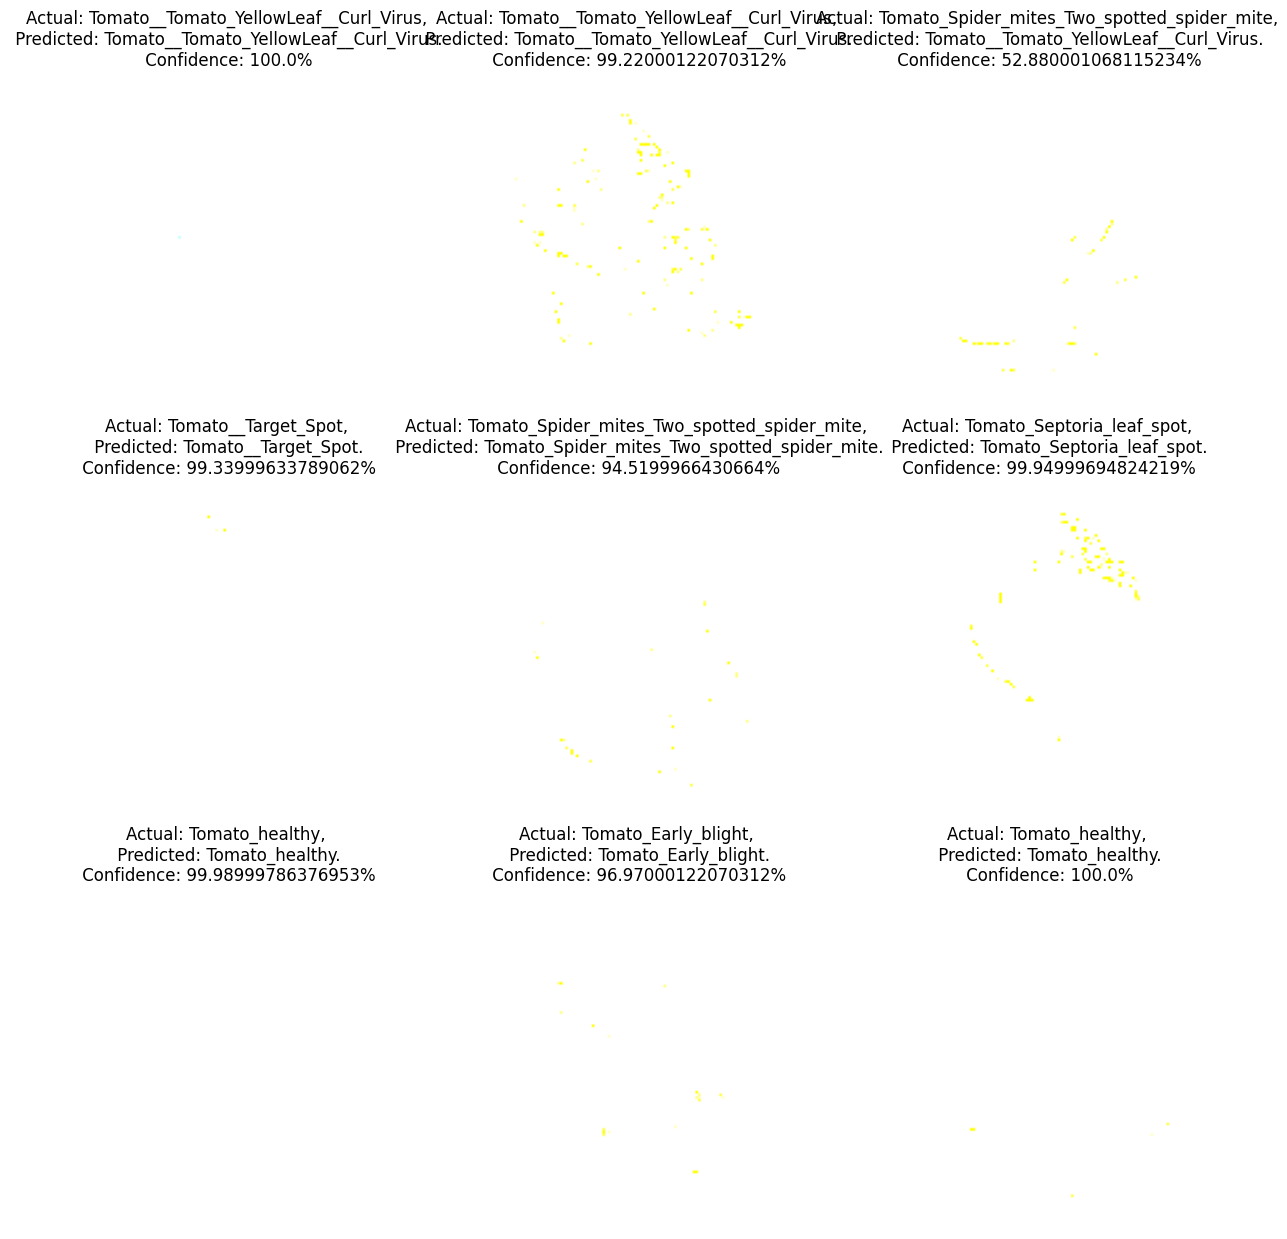

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break